In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
import os
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

train_ts = load_time_series("series_train.parquet")
test_ts = load_time_series("series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')


100%|██████████| 2/2 [00:00<00:00, 17.78it/s]


In [4]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols
train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('object')
    return df
        
train = update(train)
test = update(test)

In [5]:

# 檢視 train 和 test 資料的基本資訊
print("Train Dataset Info:")
print(train.info())
print("\nTest Dataset Info:")
print(test.info())

# 顯示缺失值分布
print("\nMissing Values in Train Dataset:")
print(train.isnull().sum().sort_values(ascending=False).head(10))

print("\nMissing Values in Test Dataset:")
print(test.isnull().sum().sort_values(ascending=False).head(10))


Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Columns: 155 entries, Basic_Demos-Enroll_Season to Stat_95
dtypes: float64(143), int64(2), object(10)
memory usage: 3.3+ MB
None

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 154 entries, Basic_Demos-Enroll_Season to Stat_95
dtypes: float64(142), int64(2), object(10)
memory usage: 24.2+ KB
None

Missing Values in Train Dataset:
PAQ_A-PAQ_A_Total               2373
Physical-Waist_Circumference    2253
Fitness_Endurance-Time_Sec      2008
Fitness_Endurance-Time_Mins     2008
Fitness_Endurance-Max_Stage     2005
FGC-FGC_GSD_Zone                1872
FGC-FGC_GSND_Zone               1872
FGC-FGC_GSD                     1865
FGC-FGC_GSND                    1864
Stat_43                         1740
dtype: int64

Missing Values in Test Dataset:
PAQ_A-PAQ_A_Total    19
Stat_19              18
Stat_47              18
Stat_41              18
Stat_42         

### 缺失值處理


- 針對連續型的資料特徵 ➡️ 使用中位數填補


In [6]:
num_imputer = SimpleImputer(strategy='median')
numerical_features = train.select_dtypes(include=['float64', 'int64']).columns
missing_in_test = [col for col in numerical_features if col not in test.columns]
for col in missing_in_test:
    test[col] = np.nan

train[numerical_features] = num_imputer.fit_transform(train[numerical_features])
test[numerical_features] = num_imputer.transform(test[numerical_features])
print("✅ Continuous numerical missing values filled with median.")


✅ Continuous numerical missing values filled with median.


- 針對類別型的資料特徵 ➡️ 使用多數填補


In [10]:
cat_imputer = SimpleImputer(strategy='most_frequent')
print(train.dtypes)
categorical_features = train.select_dtypes(include=['object']).columns
print(categorical_features)
missing_in_test = [col for col in categorical_features if col not in test.columns]
for col in missing_in_test:
    test[col] = np.nan

if categorical_features.all() :
    train[categorical_features] = cat_imputer.fit_transform(train[categorical_features])
    test[categorical_features] = cat_imputer.transform(test[categorical_features])

print("✅ Categorical missing values filled with mode.")

Basic_Demos-Enroll_Season     object
Basic_Demos-Age              float64
Basic_Demos-Sex              float64
CGAS-Season                   object
CGAS-CGAS_Score              float64
                              ...   
Stat_91                      float64
Stat_92                      float64
Stat_93                      float64
Stat_94                      float64
Stat_95                      float64
Length: 155, dtype: object
Index(['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
       'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
       'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season'],
      dtype='object')
✅ Categorical missing values filled with mode.


In [11]:
print("\n🔍 Missing Values in Train Dataset After Filling:")
print(train.isnull().sum().sort_values(ascending=False).head(10))


🔍 Missing Values in Train Dataset After Filling:
Basic_Demos-Enroll_Season    0
Stat_47                      0
Stat_40                      0
Stat_41                      0
Stat_42                      0
Stat_43                      0
Stat_44                      0
Stat_45                      0
Stat_46                      0
Stat_48                      0
dtype: int64


### 將類別型特徵進行編碼


In [12]:
le = LabelEncoder()
for col in categorical_features:
    if col == "id":
        continue
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

print("✅ 類別型特徵已進行 Label Encoding")


✅ 類別型特徵已進行 Label Encoding


### 將資料進行標準化


In [13]:
numerical_features = [col for col in numerical_features if col not in ['sii', 'id']]
scaler = StandardScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])

print("✅ 數值特徵已進行標準化")

✅ 數值特徵已進行標準化


### 儲存處理後的資料


In [14]:
train.to_csv('cleaned_train.csv', index=False)

print("✅ 處理後的資料已保存為 'cleaned_train.csv'")


✅ 處理後的資料已保存為 'cleaned_train.csv'


###


In [15]:
from sklearn.feature_selection import SelectKBest, f_regression

# 1️⃣ 移除 `sii` 和 `id`
X_train = train.drop(columns=['sii'])
y_train = train['sii']
X_test = test

# 2️⃣ 確保 `train` 和 `test` 特徵名稱一致
X_test = X_test[X_train.columns]

# 3️⃣ 特徵選擇
selector = SelectKBest(score_func=f_regression, k=120)
X_train_selected = selector.fit_transform(X_train, y_train)

# 獲取選擇的特徵名稱
selected_features = X_train.columns[selector.get_support()]
print("✅ 選擇的 120 個最佳特徵：", selected_features)

# 4️⃣ 在 `test` 中應用相同的特徵選擇
X_test_selected = X_test[selected_features].to_numpy()


✅ 選擇的 120 個最佳特徵： Index(['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height',
       'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP',
       ...
       'Stat_83', 'Stat_84', 'Stat_85', 'Stat_86', 'Stat_87', 'Stat_88',
       'Stat_89', 'Stat_90', 'Stat_94', 'Stat_95'],
      dtype='object', length=120)


In [22]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE


# 訓練分類模型
X = train[selected_features]
y = train['sii']

# 應用 SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

model = ExtraTreesClassifier(n_estimators=300, random_state=42, max_depth=5, class_weight= 'balanced', min_samples_split=5, min_samples_leaf=4)

# 交叉驗證
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kf, scoring='accuracy')

print("✅ 交叉驗證平均準確率：", cv_scores.mean())

# 模型訓練與預測
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(test[selected_features])

# 評估模型效能
print("✅ 模型評估報告：")
print(classification_report(y_train_resampled, model.predict(X_train_resampled)))

✅ 交叉驗證平均準確率： 0.6127673489458478
✅ 模型評估報告：
              precision    recall  f1-score   support

         0.0       0.58      0.81      0.67      1594
         1.0       0.71      0.32      0.44      1594
         2.0       0.67      0.48      0.56      1594
         3.0       0.68      0.98      0.80      1594

    accuracy                           0.65      6376
   macro avg       0.66      0.65      0.62      6376
weighted avg       0.66      0.65      0.62      6376



### Confusion Matrix


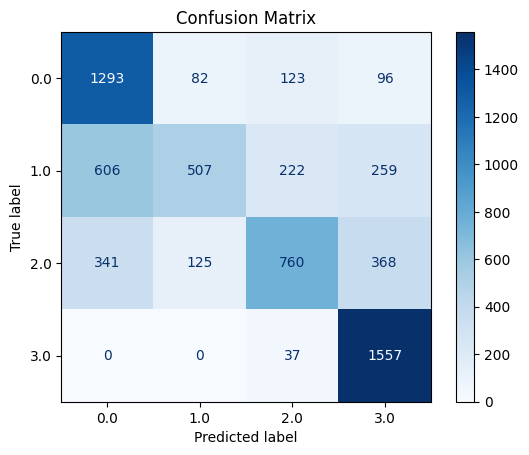

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_train_pred = model.predict(X_train_resampled)

# 混淆矩陣
cm = confusion_matrix(y_train_resampled, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


### ROC 曲線


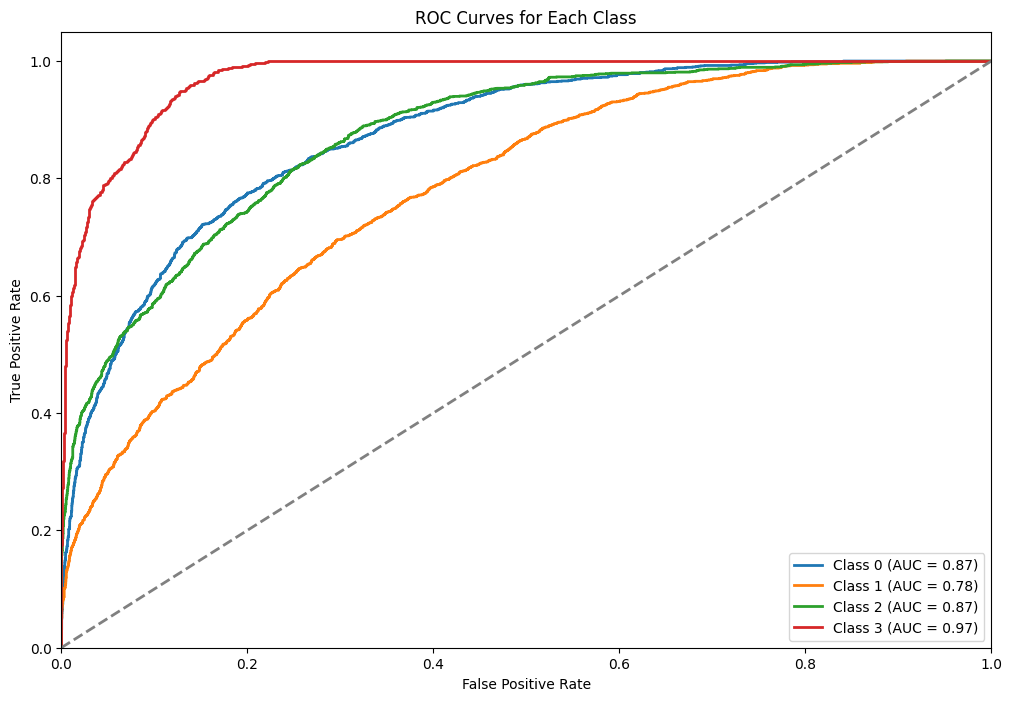

In [20]:
from sklearn.metrics import roc_curve, auc

# 獲取預測概率
y_prob = model.predict_proba(X_train_resampled)

# 繪製 ROC 曲線
plt.figure(figsize=(12, 8))
for i in range(len(model.classes_)):
    fpr, tpr, _ = roc_curve(y_train_resampled == i, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()


In [17]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import ExtraTreesClassifier

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'class_weight': ['balanced']
# }

# grid_search = GridSearchCV(
#     ExtraTreesClassifier(random_state=42),
#     param_grid,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1
# )

# grid_search.fit(X_train_resampled, y_train_resampled)
# print("✅ 最佳參數：", grid_search.best_params_)


In [17]:
# 儲存預測結果
test_id = pd.read_csv("test.csv")
submission = pd.DataFrame({'id': test_id['id'], 'sii': y_pred})
submission.to_csv('final_submission.csv', index=False)

print("✅ 預測結果已保存為 'final_submission.csv'")


✅ 預測結果已保存為 'final_submission.csv'
